# Install libraries with given versions

In [4]:
!pip install PyDrive
!pip install keras==2.2.4
!pip install tensorflow==1.13.1
!pip install git+https://github.com/darecophoenixx/wordroid.sblo.jp

     |████████████████████████████████| 317kB 3.4MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1
     |████████████████████████████████| 92.5MB 50kB/s 
     |████████████████████████████████| 368kB 41.9MB/s 
     |████████████████████████████████| 3.2MB 45.7MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4
  Cloning https://github.com/darecophoenixx/wordroid.sblo.jp to /tmp/pip-req-build-b0x7_aqf
  Running command git clone -q https://github.com/darecophoenixx/wordroid.sblo.jp /tmp/pip-req-build-b0x7_aqf
  Created wheel for wordr

# Import Libraries

In [5]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils import to_categorical
import tensorflow as tf
from keras_ex.gkernel import GaussianKernel, GaussianKernel2, GaussianKernel3
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from scipy.stats import cauchy 
from scipy import stats
import time

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

# Construct the RBF Network


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded = drive.CreateFile({'id':"1EWNv4GOWsgGXxlkMaTVJMjEAM5jaqRse"})   # replace the id with id of file you want to access
downloaded.GetContentFile('rbfnn.h5')   

In [7]:
np.random.seed(0)
num_lm0 = 100
num_lm = num_lm0 * 10
init_wgt = np.zeros(((1000, 784)))

inp = Input(shape=(28*28,), name='inp')
oup = GaussianKernel(num_lm, 28*28,
                     kernel_gamma='auto', weights=[init_wgt],
                     name='gkernel1')(inp)
oup = Dense(10, activation='softmax')(oup)
model = Model(inp, oup)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights("rbfnn.h5")

Instructions for updating:
Colocations handled automatically by placer.


# Load the Data

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def prepare_data(X,y):
  X = X.reshape((X.shape[0], -1))
  X_sc = X / 256.0
  y_cat = to_categorical(y)
  return X_sc, y_cat

In [0]:
#Example usage
#X_train, y_train = prepare_data(X_train,y_train)
#model.predict(X_train)

# Differential Evolution

In [0]:
import operator
import random

In [0]:
def euclidean(s):
    # https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
    # pass s=a-b as argument to the function
    return np.linalg.norm(s)

In [0]:
def fitness_func(individual,img):
  return (-1)*euclidean(individual-img)

def get_top_p(population,p,img):
  num_best = int(len(population)*p)
  fitness =  [(individual,fitness_func(individual,img)) for individual in population]
  fitness.sort(key=lambda x: x[1])
  fitness = fitness[-num_best:]
  return random.choice(fitness)[0]
  

## Initialization


In [0]:
#Image to be evolved
img = X_test[0].reshape((28*28, -1))
#Mean and std for Gaussian noise
mean = 0.0  
std = 1.0  
#Range
R_min = 0.0
R_max = 255.0
#Maximum number of function evaluations
nfe_max = 10000
nfe = 0
#Initial population size
PS_ini = 18
PS_min = 4
x = (1/3)*nfe_max
y = (1/3)*PS_ini
PS = PS_ini
#Number of groups
#theselectionprobability,thescalefactor and the crossover rate different per group
K = 7
p_k = np.ones((K,1))*(1/K)
#ratio of the external archive size to the whole population PS
rarc = 2.6
#archive
A_size = int(PS*rarc)
A = np.zeros((A_size,28*28))
A_ind = 0
#scale factor
f = np.ones((PS,1)) 
mu_f = np.ones((K,1)) *0.5
#crossover p
cr = np.ones((PS,1)) 
mu_cr = np.ones((K,1)) *0.5
#another p
p = 0.11
c = 0.1
#num gen
G = 1
#Initial population
population = np.zeros((PS,28*28))
V = np.zeros((PS,28*28))
U = np.zeros((PS,28*28))
for i in range(PS):
  noisy_img = img + np.random.normal(mean, std, (28*28,1))
  population[i] = np.clip(noisy_img, 0, 255).reshape(28*28)
X_best = None
X_best_fitness = None

In [103]:
nfe = 0
start = time.time()
while nfe < nfe_max:
  s_f = []
  s_f_weights = []
  s_cr = []
  s_cr_weights = []
  k_selections = []
  k_success = np.zeros((K,1))
  k_failure = np.zeros((K,1))

  if G > 2:
    #Adjust the individuals of the population; 
    for i in range(PS):
      population[i] = np.clip(population[i], 0, 255).reshape(28*28)
    #Adjust storage A; 
    for i in range(A_size):
      A[i] = np.clip(A[i], 0, 255).reshape(28*28)
    
  
  for i in range(PS):
    custm = stats.rv_discrete(name='custm', values=(np.arange(K).reshape(K,1), p_k))
    k = custm.rvs(size=1)
    k_selections.append(k)
    cr[i]  = np.random.normal(mu_cr[k], 0.1, 1)
    if cr[i] < 0:
      cr[i] = 0
    f[i] = cauchy.rvs(mu_f[k],0.1,1)
    while f[i] <= 0:
      f[i] = cauchy.rvs(mu_f[k],0.1,1)
    if f[i] > 1:
      f[i] = 1

  for i in range(PS):
    #X_p_best denotes a certain vector selector randomly from the top 100·p% 
    #individuals of the current population 
    X_p_best =  get_top_p(population,p,img).reshape((784,1))
    #X_r_1 denotes a random vector selection from the current population
    X_r_1 = random.choice(population).reshape((784,1))
    #X_hat_r_2 denotes a randomly selected solution from the union A and P
    X_hat_r_2 = random.choice(np.concatenate((population, A), axis=0)).reshape((784,1))

    #mutation
    V[i] = (population[i].reshape((784,1)) + f[i]*(X_p_best - population[i].reshape((784,1))) + f[i]*(X_r_1 - X_hat_r_2)).reshape(784)
    #crossover
    U[i] = population[i]
    for j in range(28*28):
      if random.uniform(0, 1) <= cr[i]:
        U[i][j] = V[i][j]
  
  for i in range(PS):
    k = k_selections[i]
    if fitness_func(population[i],img) <= fitness_func(U[i],img):
      s_cr.append(cr[i])
      s_cr_weights.append(np.std(np.subtract(population[i],U[i])))
      s_f.append(f[i])
      s_f_weights.append(fitness_func(U[i],img)-fitness_func(population[i],img))
      population[i] = U[i]
      k_success[k] += 1
    else:
      if A_ind == A_size:
        A_ind = 0
      A[A_ind] = population[i]
      A_ind += 1
      k_failure[k] += 1

  #update params (mixed with Jade-like update)
  if len(s_cr) != 0:
    s_cr_weights = (s_cr_weights/np.sum(s_cr_weights)).reshape((len(s_cr_weights),1))
    s_f_weights = (s_f_weights/np.sum(s_f_weights)).reshape((len(s_f_weights),1))
    mean_cr = np.sum(np.multiply(np.square(s_cr),s_cr_weights))/np.sum(np.multiply(s_cr,s_cr_weights))
    mean_f = np.sum(np.multiply(np.square(s_f),s_f_weights))/np.sum(np.multiply(s_f,s_f_weights))  
    #we can make it more group specific as discussed in the paper
    for i in range(K):
      mu_cr[i] = (1-c)*mu_cr[i] + c*mean_cr
      mu_f[i] = (1-c)*mu_f[i] + c*mean_f
  
  for i in range(K):
    if k_success[i] != 0:
      k_success[i] = np.square(k_success[i])/(np.sum(k_success)*(k_success[i]+k_failure[i]))
    else:
      p_k[i] = 0.000000001
  p_k = p_k/np.sum(p_k)

  #update pop size
  if nfe <= x:
    PS = int(np.ceil((((y-PS_ini)/np.square(x-PS_ini))*np.square(nfe-PS_ini)) + PS_ini))
  else:
    PS = int(np.ceil((((y-PS_ini)/(x-PS_min))*(nfe-nfe_max)) + PS_min))
  G += 1
  X_best = get_top_p(population,1/(len(population)),img)
  X_best_fitness = fitness_func(X_best,img)
  nfe += PS
  print(nfe, " : "  ,X_best_fitness,X_best.shape)
end = time.time()
print("Time: ",end-start)

18  :  -73044.64287155967 (784,)
36  :  -73042.25484294453 (784,)
54  :  -73031.41371629393 (784,)
72  :  -73016.58219145282 (784,)
90  :  -72991.7385796313 (784,)
108  :  -72961.0630296065 (784,)
126  :  -72927.24403771067 (784,)
144  :  -72878.161275898 (784,)
162  :  -72776.77678059258 (784,)
180  :  -72713.97913592217 (784,)
198  :  -72606.30402724109 (784,)
216  :  -72467.67616357573 (784,)
234  :  -72115.00719901743 (784,)
252  :  -71981.3831316308 (784,)
270  :  -71868.512211192 (784,)
288  :  -71639.21186383735 (784,)
306  :  -71508.83296730882 (784,)
324  :  -71356.33471153994 (784,)
342  :  -71229.14900751956 (784,)
360  :  -71224.89975346233 (784,)
378  :  -71122.89674240569 (784,)
396  :  -71089.51783061815 (784,)
414  :  -70606.39539342074 (784,)
432  :  -70583.81711472676 (784,)
450  :  -70493.91498201474 (784,)
468  :  -70476.00273719332 (784,)
486  :  -70238.1346857214 (784,)
504  :  -70069.72863734826 (784,)
522  :  -70064.0174192156 (784,)
540  :  -69985.53953867013 (

IndexError: ignored

## ToDo
* Personalize wrt group the mu parameters.
* The population can also increase. Try to allocate the array smartly to overcome this problem.
* Check hyperparameters
* Fix the loss


In [133]:
#Truth:7
y_test[0]

7

In [132]:
#Model predicts: 7
X_test_sc = X_test/255.0
preds = model.predict(X_test_sc[0].reshape((1,28*28)))
np.argmax(preds,axis=1)

array([7])

In [0]:
X_best_sc = X_best / 255.0

In [135]:
#Predicts evolved example:7
model.predict(X_best_sc.reshape((1,28*28)))

array([[1.0185721e-04, 6.8408804e-07, 1.2421128e-04, 5.9431945e-03,
        2.0786927e-05, 6.9741259e-04, 1.5578987e-08, 9.9124545e-01,
        1.9608623e-04, 1.6703642e-03]], dtype=float32)

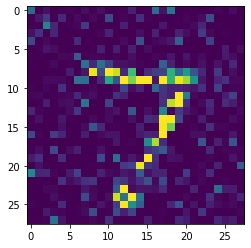

In [111]:
plt.imshow(X_best.reshape((28,28)))

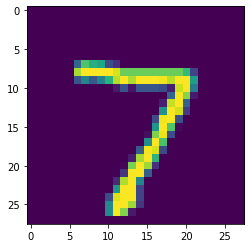

In [116]:
plt.imshow(X_test[0].reshape((28,28)))

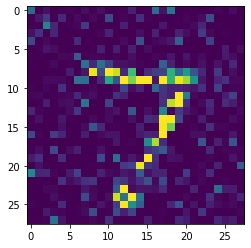

In [136]:
plt.imshow((X_best/255.0).reshape((28,28)))

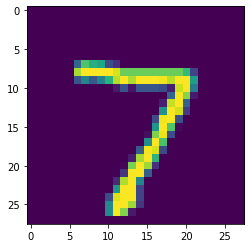

In [137]:
plt.imshow((X_test[0]/255.0).reshape((28,28)))